# CNN Test


Process outline
1. Prepare time delay features
2. Spatial aggregation
   - Area weighted sum for precipitation features
   - Area mean for all other features
3. Define the model
4. Train the model
   - Reshape the input dataset to the model specific `X` and `y` arrays
   - Actually train on `X` and `y`

In [2]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import keras

Using TensorFlow backend.
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint1

## Loading the data
Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data. Let's open the files and see what's in there:

In [228]:
n = 1000
t = np.linspace(0,9*np.pi,n)
x = np.zeros(n)

In [229]:
t.shape, x.shape

((1000,), (1000,))

In [230]:
mask = (t>np.pi)&(t<2*np.pi)
x[mask] += np.sin(t[mask])**2

mask = (t>3*np.pi)&(t<4*np.pi)
x[mask] += np.sin(t[mask])**2

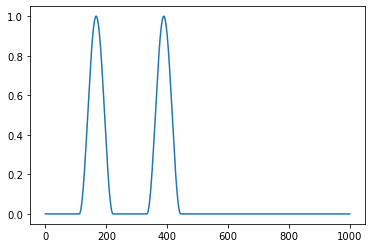

In [231]:
plt.plot(x)

In [232]:
#mask = (t>3*np.pi/2)&(t<2*np.pi)
#x[mask] += np.sin(2*t[mask])**2/2


mask = (t>2*np.pi)&(t<3*np.pi)
x[mask] += np.sin(t[mask])**2/2

mask = (t>4*np.pi)&(t<5*np.pi)
x[mask] += np.sin(t[mask])**2/2

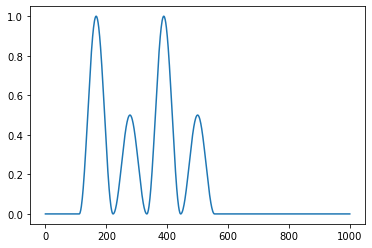

In [233]:
plt.plot(x)

In [234]:
y = x.copy()
for i in range(1,len(y)):
    y[i] = y[i-1] - y[i-1]/100 +  x[i]/2
    

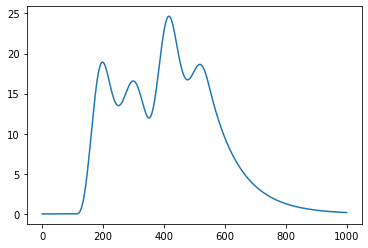

In [235]:
plt.plot(y)

In [236]:
from keras.layers import Dense
from keras.models import Input, Model
from keras.preprocessing.sequence import TimeseriesGenerator
from tcn import TCN

In [237]:
batch_size = None
timesteps = 30
input_dim = 1

i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False)(i)  # The TCN layers are here.
o = Dense(1)(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam', loss='mse')

In [238]:
x = x[:,np.newaxis]  # only one predictand so far
x.shape

(1000, 1)

In [239]:
length = timesteps
data_gen = TimeseriesGenerator(x, y, length, batch_size=x.shape[0])
Xt, yt = data_gen[0]

if len(y.shape)==1:
    yt = yt.reshape(-1, 1)

Xt.shape, yt.shape


((970, 30, 1), (970, 1))

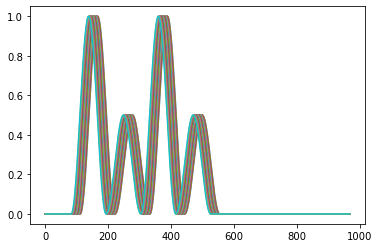

In [240]:
plt.plot(Xt[:,:,0])

In [241]:
m.fit(Xt, yt, epochs=30, validation_split=0.2)

Train on 776 samples, validate on 194 samples
Epoch 1/30
776/776 [==============================] - 5s 6ms/step - loss: 38.6389 - val_loss: 16.2846
Epoch 2/30
776/776 [==============================] - 2s 3ms/step - loss: 19.8087 - val_loss: 8.7024
Epoch 3/30
776/776 [==============================] - 2s 3ms/step - loss: 17.3540 - val_loss: 8.1294
Epoch 4/30
776/776 [==============================] - 2s 3ms/step - loss: 12.4564 - val_loss: 7.0315
Epoch 5/30
776/776 [==============================] - 2s 3ms/step - loss: 10.7864 - val_loss: 6.1376
Epoch 6/30
776/776 [==============================] - 2s 3ms/step - loss: 10.4303 - val_loss: 4.6911
Epoch 7/30
776/776 [==============================] - 2s 3ms/step - loss: 10.3580 - val_loss: 4.7607
Epoch 8/30
776/776 [==============================] - 3s 3ms/step - loss: 10.1169 - val_loss: 9.5636
Epoch 9/30
776/776 [==============================] - 2s 3ms/step - loss: 10.6586 - val_loss: 12.6057
Epoch 10/30
776/776 [======================

In [242]:
yp = m.predict(Xt)
yp.shape

(970, 1)

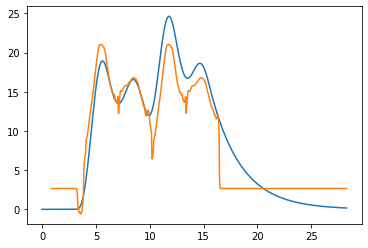

In [243]:
plt.plot(t, y)
plt.plot(t[timesteps:], yp)